# Text Clssification Mini Project 2

## 1. Data Loading and Exploration

### 1.1 Importing the necessary libraries:

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from scipy.sparse import csr_matrix, hstack
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from textblob import TextBlob
from nrclex import NRCLex
import seaborn as sns
import contractions
import pandas as pd
import math
import re
# Import Additional Libraries for embedding_word
from embedding_word import *



# Import Spacy libary
import spacy

# Load the pre-trained spaCy model
nlp = spacy.load('en_core_web_sm')

### 1.2 Data Loading

Read positive and negative reviews

In [2]:
# Read positive and negative reviews

positive_reviews = open('Mini_Project_2_Data/positive-reviews.txt', encoding='utf-8').read().splitlines()
negative_reviews = open('Mini_Project_2_Data/negative-reviews.txt', encoding='utf-8').read().splitlines()

Read positive and negative words from files

In [4]:
# Read positive and negative words from files

# positive_words = set(open('Mini_Project_2_Data/positive-words.txt').read().splitlines())
# negative_words = set(open('Mini_Project_2_Data/negative-words.txt').read().splitlines())

positive_words = set(open('Mini_Project_2_Data/positive-words.txt', encoding='utf-8').read().splitlines())
negative_words = set(open('Mini_Project_2_Data/negative-words.txt', encoding='latin-1').read().splitlines())


Combine to Dataframe

In [5]:
# Combine negative and positive reviews
reviews = negative_reviews + positive_reviews

# Create a DataFrame with a 'Reviews' column
df = pd.DataFrame({'Reviews': reviews})

# Create labels
labels = [0] * len(negative_reviews) + [1] * len(positive_reviews)

# Add a 'Label' column to the DataFrame
df['Label'] = labels


In [6]:
df = df.sample(frac=1).reset_index(drop=True)
df

,Reviews,Label
0,Power full Camera!,1
1,"Not flashy, if you're into that sort of thing....",0
2,"great image quality, easy to use, can use micr...",1
3,Can't use it as a modem or transfer ringtones ...,0
4,"small size, price",1
...,...,...
39995,nothing,0
39996,"Compact, excellent quality print, well-built",1
39997,"Best Price offered , Long Life battrey Charge",1
39998,"Fast, great colors and resolution.",1


<Axes: xlabel='Label'>

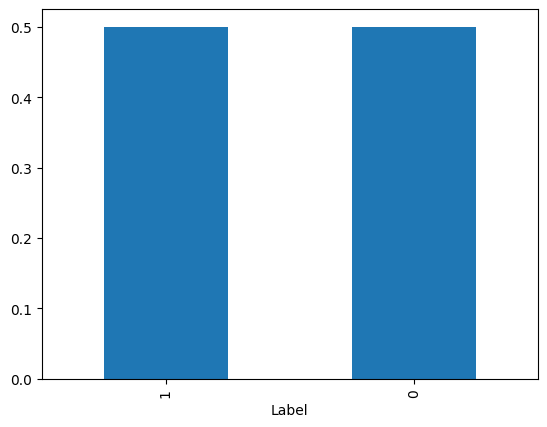

In [7]:
df['Label'].value_counts(normalize = True).plot.bar()

## 2. Text Preprocessing and Cleaning


### 2.1 Cleaning 

In [8]:
# Remove newline characters from the 'review_text' column
df['Reviews'] = df['Reviews'].str.strip()

In [9]:
# Check if there are None rows
none_rows = df[df['Reviews'] == 'None']
none_rows

,Reviews,Label
70,None,0
153,None,0
330,None,0
351,None,0
355,None,0
...,...,...
39069,None,0
39101,None,0
39707,None,0
39923,None,1


In [10]:
# Filter rows where 'review_text' is not 'None'
df = df[df['Reviews'] != 'None']

# Reset index after dropping rows
df.reset_index(drop=True, inplace=True)

# Check if there are None rows
none_rows = df[df['Reviews'] == 'None']
none_rows

,Reviews,Label


+ Check Duplicate Data

In [11]:
df.duplicated().sum()

3151

In [12]:
df = df.drop_duplicates()
df.duplicated().sum()

0

+ Check if it null

In [13]:
df.isnull().sum()

Reviews    0
Label      0
dtype: int64

### 2.2 Text Preprocessing

Define a function for text preprocessing and store the results in a new column called **'cleaned_review_text'**.

1. **Remove extra spaces**:
   - Using regular expressions, eliminate any redundant spaces within the text.

2. **Convert text to lowercase**:
   - Convert all characters in the text to lowercase to ensure uniformity.

3. **Expand contractions**:
   - Utilize the `contractions.fix()` function to expand contracted words in the text.

4. **Replace repetitions of punctuation with a single punctuation**:
   - Employ regular expressions to replace consecutive occurrences of punctuation with a single instance.

5. **Remove punctuation (except '!') and numbers**:
   - Use regular expressions to eliminate all punctuation marks and numerical digits from the text, with the exception of the exclamation mark '!'.

6. **Remove emojis**:
   - Utilize either regular expressions or a library to remove emojis from the text.

7. **Tokenize text**:
   - Segment the text into individual words or tokens using a tokenizer.

8. **Remove stop words except 'no' and 'not'**:
   - Exclude common stop words, which are words that typically do not carry significant meaning, from the text. However, retain the words 'no' and 'not' as they can alter the meaning of a sentence.

9. **Lemmatization**:
   - Apply lemmatization to reduce each word to its base or dictionary form, considering the context of the word in the sentence.

10. **Join tokens back into text**:
    - Reassemble the processed tokens into coherent text after preprocessing.



In [14]:
def text_preprocessing(text):
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)

    # Convert text to lowercase
    text = text.lower()

    # Expand contractions
    text = contractions.fix(text)

    # Replace repetitions of punctuation with a single punctuation mark
    text = re.sub(r'(\W)\1+', r'\1', text)

    # Remove punctuation(except !) and numbers
    text = re.sub(r'[^a-zA-Z!]+', ' ', text)

    # Remove emojis
    text = text.encode('ascii', 'ignore').decode('ascii')

    # Tokenize text using SpaCy
    doc = nlp(text)
    tokens = [token.text for token in doc]

    # Remove stop words except 'no' and 'not' - SpaCy has its own stop words list
    tokens = [token for token in tokens if not nlp.vocab[token].is_stop or token in {'no', 'not'}]

    # Lemmatization - SpaCy performs lemmatization automatically
    tokens = [token.lemma_ for token in doc]

    # Return Join tokens back into text
    cleaned_text = ' '.join(tokens)

    return cleaned_text

+ Apply clean text to datafram

In [15]:
# Apply the function to the 'review_text' column and store the results in a new column 'cleaned_review_text'
df['cleaned_review_text'] = df['Reviews'].apply(text_preprocessing)

df

,Reviews,Label,cleaned_review_text
0,Power full Camera!,1,power full camera !
1,"Not flashy, if you're into that sort of thing....",0,not flashy if you be into that sort of thing j...
2,"great image quality, easy to use, can use micr...",1,great image quality easy to use can use microd...
3,Can't use it as a modem or transfer ringtones ...,0,can not use it as a modem or transfer ringtone...
4,"small size, price",1,small size price
...,...,...,...
39695,"non rechargable battery, 'optional' AC adapter,",0,non rechargable battery optional ac adapter
39697,"Compact, excellent quality print, well-built",1,compact excellent quality print well build
39698,"Best Price offered , Long Life battrey Charge",1,good price offer long life battrey charge
39699,"Fast, great colors and resolution.",1,fast great color and resolution


### 2.3 Data Virtualization 

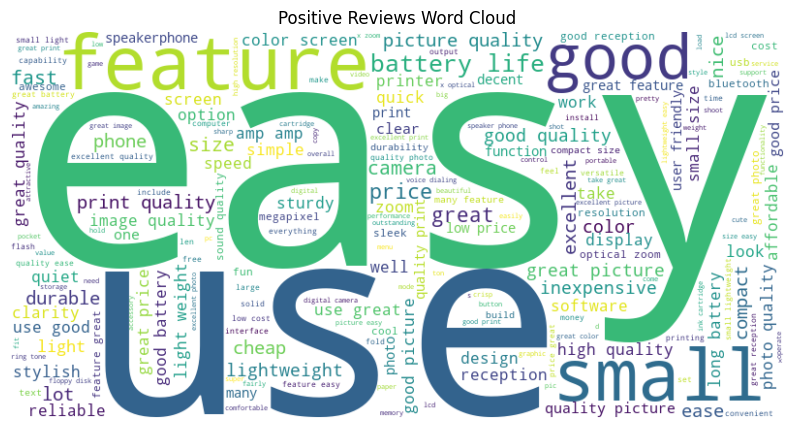

In [20]:
from wordcloud import WordCloud
#Positive Reviews Word Cloud
positive_reviews = ' '.join(df[df['Label'] == 1]['cleaned_review_text'])

plt.figure(figsize=(10, 8))
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Reviews Word Cloud') 
plt.axis('off')
plt.show()

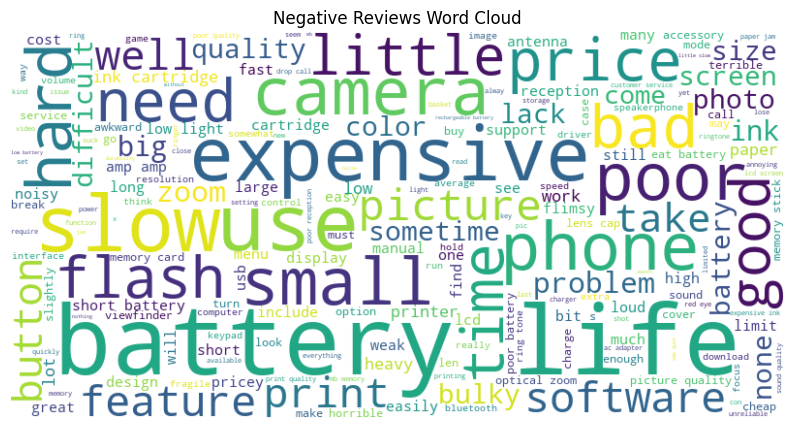

In [21]:
#Negative Reviews Word Cloud
negative_reviews = ' '.join(df[df['Label'] == 0]['cleaned_review_text'])

plt.figure(figsize=(10, 8))
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Reviews Word Cloud')
plt.axis('off')

plt.show()

In [22]:
from collections import Counter

def get_top_words(text, n=10):
    words = text.split()
    return Counter(words).most_common(n)

top_positive_words = get_top_words(positive_reviews)
top_negative_words = get_top_words(negative_reviews)

print("\nTop 10 Positive Words:")
print(top_positive_words)

print("\nTop 10 Negative Words:")
print(top_negative_words)


Top 10 Positive Words:
[('quality', 4498), ('to', 4344), ('great', 3963), ('easy', 3927), ('use', 3804), ('and', 3790), ('good', 3541), ('of', 2327), ('feature', 2321), ('small', 2042)]

Top 10 Negative Words:
[('be', 3909), ('not', 3774), ('to', 3057), ('battery', 2793), ('a', 2637), ('no', 2619), ('the', 2334), ('and', 1788), ('of', 1603), ('life', 1369)]


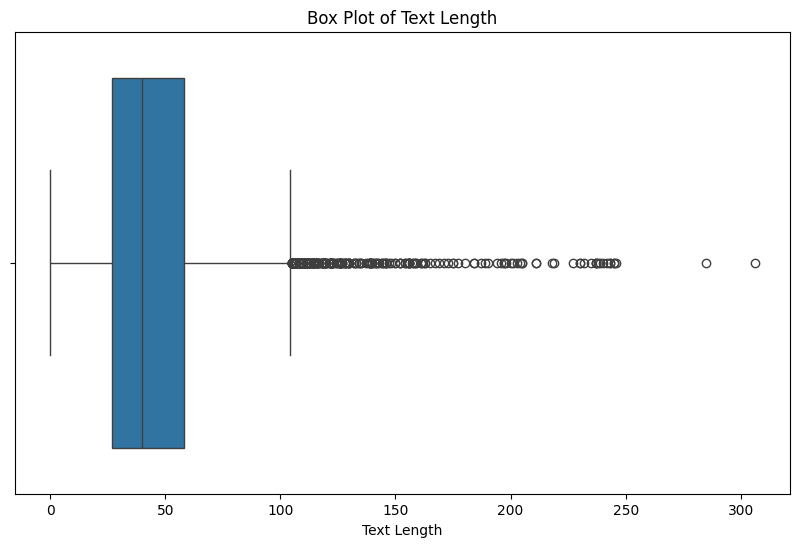

In [23]:
#Outlier Detection
import seaborn as sns

df['text_length'] = df['cleaned_review_text'].apply(len)

Q1 = df['text_length'].quantile(0.25)
Q3 = df['text_length'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['text_length'] < lower_bound) | (df['text_length'] > upper_bound)]

# Visualizing outliers with a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['text_length'])
plt.title('Box Plot of Text Length')
plt.xlabel('Text Length')
plt.show()

## 3. Feature Extraction from Text

## 3. Feature Extraction from Text

### 3.1 Count of Positive and Negative Words in Review Text
This analysis provides a breakdown of the number of positive and negative words found in the review text. Positive and negative sentiments are quantified to gain insights into the overall tone of the reviews.


In [24]:
def count_positive_words(text):

    words = text.lower().split()
    count = sum(1 for word in words if word in positive_words)
    return count

def count_negative_words(text):

    words = text.lower().split()
    count = sum(1 for word in words if word in negative_words)
    return count

+ Apply count_negative_words and count_positive_words

In [25]:
# Apply function count_positive_words and count_negative_words to cleaned_review_text
df['count_positive_words'] = df['cleaned_review_text'].apply(count_positive_words)
df['count_negative_words'] = df['cleaned_review_text'].apply(count_negative_words)

### 3.2 Check for Presence of 'no' or 'not' in Review Text
This analysis examines whether the review text includes the words 'no' or 'not'. Identifying the presence of these words can be crucial for understanding negation in the sentiment expressed within the reviews.


In [26]:
def contain_no(cleaned_review_text):
    tokens = word_tokenize(cleaned_review_text)
    contain_no = int('no' in tokens)
    return contain_no

def contain_not(cleaned_review_text):
    tokens = word_tokenize(cleaned_review_text)
    contain_not = int('not' in tokens)
    return contain_not

+ Apply function contains_no and contains_not to cleaned_review_text

In [27]:
# Apply function contains_no and contains_not to cleaned_review_text
df['contain_no'] = df['cleaned_review_text'].apply(contain_no)
df['contain_not'] = df['cleaned_review_text'].apply(contain_not)

In [28]:
df.head(10)

,Reviews,Label,cleaned_review_text,text_length,count_positive_words,count_negative_words,contain_no,contain_not
0,Power full Camera!,1,power full camera !,19,0,0,0,0
1,"Not flashy, if you're into that sort of thing....",0,not flashy if you be into that sort of thing j...,71,3,0,0,1
2,"great image quality, easy to use, can use micr...",1,great image quality easy to use can use microd...,50,2,0,0,0
3,Can't use it as a modem or transfer ringtones ...,0,can not use it as a modem or transfer ringtone...,80,0,1,0,1
4,"small size, price",1,small size price,16,0,0,0,0
5,"very convenient, great price",1,very convenient great price,27,2,0,0,0
6,"Runs out of ink fast, poor color quality, scan...",0,run out of ink fast poor color quality scanner...,62,1,1,0,0
7,"Poor earpiece volume, feels fragile at times, ...",0,poor earpiece volume feel fragile at times sto...,68,0,3,0,0
8,none noted.,0,none note,9,0,0,0,0
9,"This camera is slow to turn on, and does not h...",0,this camera be slow to turn on and do not have...,69,1,1,0,1


### 3.3 Check for Presence of '!' in Review Text
This analysis looks for the presence of the exclamation mark '!' within the review text. The presence of '!' can indicate emphasis or heightened emotion in the expressed sentiments.


In [29]:
def contain_exclamation(cleaned_review_text):
    tokens = word_tokenize(cleaned_review_text)
    contain_exclamation = int('!' in tokens)
    return contain_exclamation

+ Apply function contain_exclamation to cleaned_review_text

In [30]:
# Apply function contain_exclamation to cleaned_review_text
df['contain_exclamation'] = df['cleaned_review_text'].apply(contain_exclamation)

In [31]:
df.head(10)

,Reviews,Label,cleaned_review_text,text_length,count_positive_words,count_negative_words,contain_no,contain_not,contain_exclamation
0,Power full Camera!,1,power full camera !,19,0,0,0,0,1
1,"Not flashy, if you're into that sort of thing....",0,not flashy if you be into that sort of thing j...,71,3,0,0,1,0
2,"great image quality, easy to use, can use micr...",1,great image quality easy to use can use microd...,50,2,0,0,0,0
3,Can't use it as a modem or transfer ringtones ...,0,can not use it as a modem or transfer ringtone...,80,0,1,0,1,0
4,"small size, price",1,small size price,16,0,0,0,0,0
5,"very convenient, great price",1,very convenient great price,27,2,0,0,0,0
6,"Runs out of ink fast, poor color quality, scan...",0,run out of ink fast poor color quality scanner...,62,1,1,0,0,0
7,"Poor earpiece volume, feels fragile at times, ...",0,poor earpiece volume feel fragile at times sto...,68,0,3,0,0,0
8,none noted.,0,none note,9,0,0,0,0,0
9,"This camera is slow to turn on, and does not h...",0,this camera be slow to turn on and do not have...,69,1,1,0,1,0


### 3.4 Log of Review Text Length
This analysis calculates the logarithm of the length of the review text. Taking the logarithm of the length can help normalize the data and highlight differences in text length more effectively.


In [61]:
def log_review_length(review_text):
    review_length = len(review_text)
    if review_length == 0:
        return 0  # Return 0 if the review length is 0
    log_length = math.log(review_length)
    return log_length

+ Apply function log_review_length to cleaned_review_text

In [62]:
# Apply function log_review_length to cleaned_review_text
df['log_review_length'] = df['cleaned_review_text'].apply(log_review_length)

### 3.5 Count of Words with POS Tags (Pronouns, Adjectives)
This analysis counts the number of words in the review text that are tagged as Pronouns and Adjectives. Pronouns and adjectives play a significant role in conveying sentiment and describing characteristics, making their frequency useful for sentiment analysis.


In [63]:
def count_pos_words(review_text, pos_tag):
    doc = nlp(review_text)
    count = sum(1 for token in doc if token.pos_ == pos_tag)
    return count

+ Apply function count_pos_words to cleaned_review_text

In [64]:
# df['pronoun_count'] = df['cleaned_review_text'].apply(lambda x: count_pos_words(x, 'PRON'))
# df['adjective_count'] = df['cleaned_review_text'].apply(lambda x: count_pos_words(x, 'ADJ'))
# df['adverb_count'] = df['cleaned_review_text'].apply(lambda x: count_pos_words(x, 'ADV'))

### 3.6 Emotion Label Based on Review Text
This analysis assigns an emotion label to each review text based on the predominant emotion expressed. Emotions such as joy, sadness, anger, surprise, and others may be identified using sentiment analysis techniques, helping to categorize the overall emotional tone of the reviews.


In [65]:
def get_emotion_label(phrase):
    # Tokenize the phrase
    tokens = word_tokenize(phrase)

    # Define emotion word list
    emotion_words = []

    for i in range(len(tokens)):
      # Call NRCLex constructor
      emotion = NRCLex(tokens[i])
      # Get affect_dict
      affect_dict = emotion.affect_dict
      # Extract emotion words from affect_dict values
      for sublist in affect_dict.values():
        emotion_words.extend(sublist)

    # Define positive and negative emotion groups
    positive_emotions = ['anticipation', 'trust', 'positive', 'joy', 'surprise']
    negative_emotions = ['fear', 'anger', 'negative', 'sadness', 'disgust']

    # Count occurrences of positive and negative words
    positive_count = sum(emotion_words.count(emotion) for emotion in positive_emotions)
    negative_count = sum(emotion_words.count(emotion) for emotion in negative_emotions)

    # Determine sentiment label based on counts
    if positive_count > negative_count:
        return 1
    elif positive_count < negative_count:
        return 0
    else:
        return 2

# # Sample usage
# phrase = "This movie is great and wonderful, but it made me sad."
# emotion_label = get_emotion_label(phrase)
# print("Emotion label:", emotion_label)

+ Apply function get_emotion_label to cleaned_review_text

In [66]:
# Apply function get_emotion_label to cleaned_review_text
df['emotion_label'] = df['cleaned_review_text'].apply(get_emotion_label)

### 3.7 Sentiment Score Calculation
This analysis computes the sentiment score for each review text. The sentiment score quantifies the overall sentiment expressed in the review, typically ranging from negative to positive values.


In [67]:
def calculate_sentiment_score(phrase):
    # Create a TextBlob object
    blob = TextBlob(phrase)

    # Get the sentiment score
    sentiment_score = blob.sentiment.polarity

    return sentiment_score

# Sample usage
# phrase = "This movie is great and wonderful, but it made me sad."
# sentiment_score = calculate_sentiment_score(phrase)
# print("Sentiment score:", sentiment_score)

+ Apply function calculate_sentiment_score to cleaned_review_text

In [68]:
# Apply function calculate_sentiment_score to cleaned_review_text
df['sentiment_score'] = df['cleaned_review_text'].apply(calculate_sentiment_score)

## 4. Classification Model Building


### 4.1 Train-Test Split for Model Evaluation

In [69]:
df = df.drop('Reviews',axis=1)

In [70]:
y = df['Label']
X = df.drop(columns=['Label'],axis=1)

In [71]:
# Train a Word2Vec model
cleaned_reviews = [review.split() for review in df['cleaned_review_text']]
model = Word2Vec(sentences=cleaned_reviews, vector_size=100, window=5, min_count=1, workers=4)

# Convert text data using Word2Vec embeddings
X_text_transformed = text_to_word_embeddings(df['cleaned_review_text'], model)

# Convert numeric features to arrays
X_numeric_features = X.drop(columns=['cleaned_review_text']).values

# Convert numeric features to sparse matrices
X_numeric_sparse = csr_matrix(X_numeric_features)

# Concatenate the word embeddings and other features
X = hstack([X_text_transformed, X_numeric_sparse])


In [72]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split( X , df['Label'], test_size=0.2, random_state=42, stratify= df['Label'])

In [73]:
scaler = MaxAbsScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Convert the sparse matrix to a dense array for visualization
X_train_dense = X_train.toarray()
X_train_scaled_dense = X_train_scaled.toarray()

# Create a DataFrame for better visualization (optional)
columns = [f'Feature_{i}' for i in range(X_train_dense.shape[1])]
X_train_df = pd.DataFrame(data=X_train_dense, columns=columns)
X_train_scaled_df = pd.DataFrame(data=X_train_scaled_dense, columns=columns)


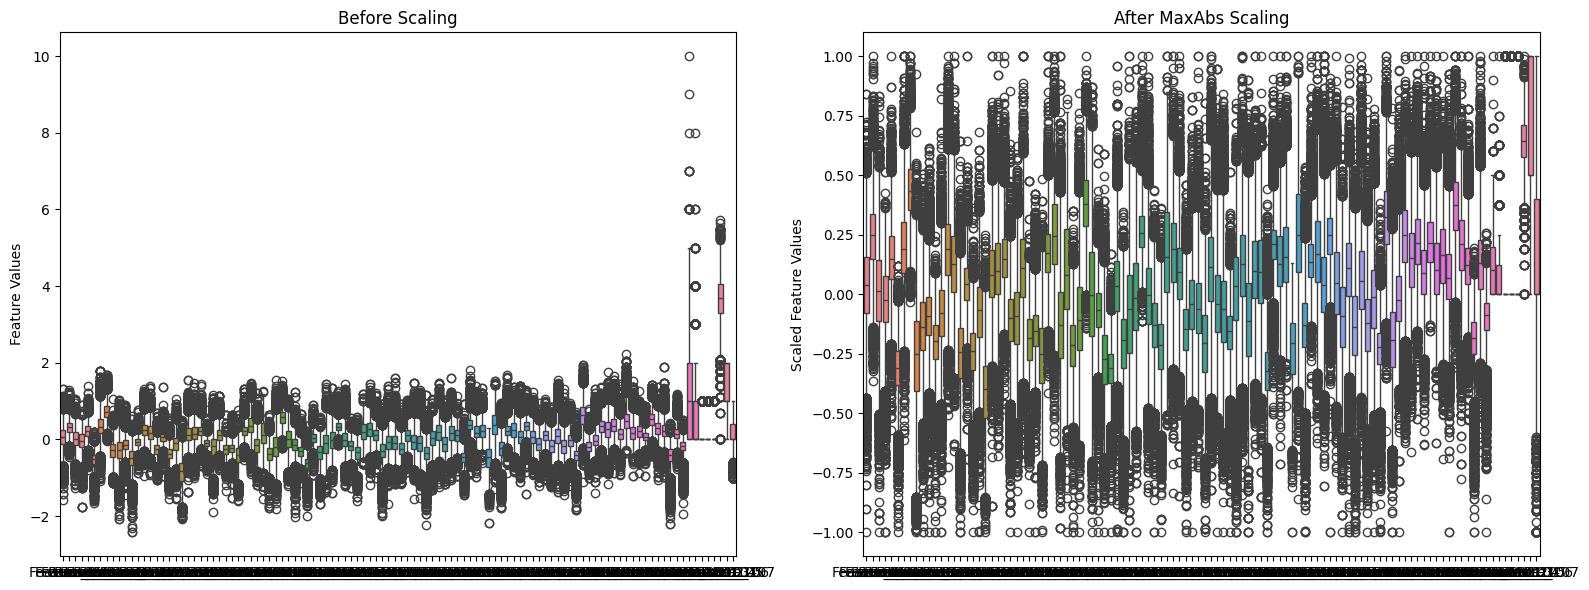

In [74]:

# Plot side-by-side boxplots
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=X_train_df, orient='v')
plt.title('Before Scaling')
plt.ylabel('Feature Values')

plt.subplot(1, 2, 2)
sns.boxplot(data=X_train_scaled_df, orient='v')
plt.title('After MaxAbs Scaling')
plt.ylabel('Scaled Feature Values')

plt.tight_layout()
plt.show()


### 4.3 Model Training: Multinomial Naive Bayes Classifier ( MultinomialNB )

#### 4.3.1 Using with Countvector

In [75]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
nb_countvec = MultinomialNB()

In [76]:
X_train_texts = [" ".join(map(str, row.data)) for row in csr_matrix(X_train_scaled_df)]

+ Convert X_Train to vecounter

In [77]:
X_train_count_vect = vectorizer.fit_transform(X_train_texts)

In [78]:
nb_countvec.fit(X_train_count_vect ,y_train)

MultinomialNB()

#### 4.3.2 Using with TF-IDF

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vectorizer = TfidfVectorizer()

nb_tfidf = MultinomialNB()

In [80]:
X_train_tf_idf_vect = tf_idf_vectorizer.fit_transform(X_train_texts)

In [81]:
nb_tfidf.fit(X_train_tf_idf_vect,y_train)

MultinomialNB()

### 4.4 Model Training: Logistic Regression

In [82]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

In [83]:
lr.fit(X_train,y_train)

c:\Users\kimh1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

### 4.5 Model Training: Random Forest 

In [84]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

In [85]:
rf.fit(X_train,y_train)

RandomForestClassifier()

### 4.6 Model Training: xgboost classifier 

In [86]:
from xgboost import XGBClassifier

# Correct variable name for XGBClassifier
xgb = XGBClassifier()

In [87]:
xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### 4.7 Model Training: Support Vector Machine (SVM) 

In [88]:
from sklearn import svm

clf = svm.SVC(kernel='linear') # Linear Kernel


In [89]:
clf.fit(X_train, y_train)

SVC(kernel='linear')

### 4.8 Model Training: Multi-layer Perceptron classifier (MLPClassifier)

In [90]:
from sklearn.neural_network import MLPClassifier

# Correct variable name for MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)


In [91]:
mlp.fit(X_train_scaled_df,y_train)

c:\Users\kimh1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(max_iter=300, random_state=42)

## 5. Model Evaluation and Accuracy Metrics 

In [92]:
X_test_numeric_scaled = scaler.transform(X_test)

In [93]:
X_test_texts = [" ".join(map(str, row.data)) for row in X_test_numeric_scaled]

In [94]:
X_test_count_vect = vectorizer.transform(X_test_texts )
X_test_tfidf_vect = tf_idf_vectorizer.transform(X_test_texts )

In [95]:
multinomialnb_predictions_with_count_vect = nb_countvec.predict(X_test_count_vect)
multinomialnb_predictions_with_tfidf = nb_tfidf.predict(X_test_tfidf_vect)

In [96]:
# Make predictions
logistic_regression_predictions = lr.predict(X_test_numeric_scaled)
random_forest_predictions = rf.predict(X_test_numeric_scaled)
MLPClassifier_predictions = mlp.predict(X_test_numeric_scaled)
xgbclassifier_predictions = xgb.predict(X_test_numeric_scaled)
svm_predictions = clf.predict(X_test_numeric_scaled)


c:\Users\kimh1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


In [97]:
print("Multinomial Naive Bayes Predictions with CountVectorizer:", multinomialnb_predictions_with_count_vect)
print("Multinomial Naive Bayes Predictions with TF-IDF:", multinomialnb_predictions_with_tfidf)
print("Logistic Regression Predictions :", logistic_regression_predictions)
print("Random Forest Predictions :", random_forest_predictions )
print("MLPClassifier Predictions :", MLPClassifier_predictions)
print("XGBoost Classifier Predictions :", xgbclassifier_predictions)
print("SVM Predictions :", svm_predictions)


Multinomial Naive Bayes Predictions with CountVectorizer: [1 1 1 ... 1 0 1]
Multinomial Naive Bayes Predictions with TF-IDF: [1 1 1 ... 1 0 1]
Logistic Regression Predictions : [0 1 0 ... 1 0 0]
Random Forest Predictions : [0 1 0 ... 1 1 0]
MLPClassifier Predictions : [0 1 0 ... 1 1 0]
XGBoost Classifier Predictions : [0 1 0 ... 1 1 0]
SVM Predictions : [0 1 0 ... 1 0 0]


In [98]:
# Calculate accuracy for each classifier
accuracy_multinomialnb_count_vect = accuracy_score(y_test, multinomialnb_predictions_with_count_vect)
accuracy_multinomialnb_tfidf = accuracy_score(y_test, multinomialnb_predictions_with_tfidf)
accuracy_logistic_regression = accuracy_score(y_test, logistic_regression_predictions)
accuracy_random_forest = accuracy_score(y_test, random_forest_predictions)
accuracy_MLPClassifier = accuracy_score(y_test, MLPClassifier_predictions)
accuracy_xgbclassifier = accuracy_score(y_test, xgbclassifier_predictions)
accuracy_svm = accuracy_score(y_test, svm_predictions)

# Print accuracy for each classifier
print("Accuracy - Multinomial Naive Bayes with CountVectorizer:", accuracy_multinomialnb_count_vect)
print("Accuracy - Multinomial Naive Bayes with TF-IDF:", accuracy_multinomialnb_tfidf)
print("Accuracy - Logistic Regression:", accuracy_logistic_regression)
print("Accuracy - Random Forest:", accuracy_random_forest)
print("Accuracy - MLPClassifier:", accuracy_MLPClassifier)
print("Accuracy - XGBoost Classifier:", accuracy_xgbclassifier)
print("Accuracy - SVM:", accuracy_svm)


Accuracy - Multinomial Naive Bayes with CountVectorizer: 0.7302325581395349
Accuracy - Multinomial Naive Bayes with TF-IDF: 0.7303693570451436
Accuracy - Logistic Regression: 0.8548563611491108
Accuracy - Random Forest: 0.887688098495212
Accuracy - MLPClassifier: 0.9290013679890561
Accuracy - XGBoost Classifier: 0.8976744186046511
Accuracy - SVM: 0.8589603283173735


## 6. Predictions on Example Reviews 

In [99]:
# Example Reviews
new_reviews = [
    "This movie was fantastic! I loved every moment of it.",
    "The product quality was terrible. I regret buying it.",
    "The customer service was amazing. They resolved my issue promptly.",
    "I have never experienced such poor service. Avoid this company.",
    "The book was captivating and well-written. Highly recommend it.",
]

# Text Preprocessing for New Reviews
cleaned_new_reviews = [text_preprocessing(review) for review in new_reviews]

# Convert new reviews to Word2Vec embeddings
new_reviews_transformed = text_to_word_embeddings(cleaned_new_reviews, model)

# Convert numeric features for new reviews
new_reviews_numeric_features = pd.DataFrame({
    'count_positive_words': [count_positive_words(review) for review in cleaned_new_reviews],
    'count_negative_words': [count_negative_words(review) for review in cleaned_new_reviews],
    'contain_no': [contain_no(review) for review in cleaned_new_reviews],
    'contain_not': [contain_not(review) for review in cleaned_new_reviews],
    'contain_exclamation': [contain_exclamation(review) for review in cleaned_new_reviews],
    'log_review_length': [log_review_length(review) for review in cleaned_new_reviews],
    'emotion_label': [get_emotion_label(review) for review in cleaned_new_reviews],
    'sentiment_score': [calculate_sentiment_score(review) for review in cleaned_new_reviews],
})

# Concatenate the word embeddings and other features for new reviews
new_reviews_data = hstack([new_reviews_transformed, csr_matrix(new_reviews_numeric_features)])


In [100]:

# Scale the new reviews data using MaxAbsScaler
new_reviews_scaled = scaler.transform(new_reviews_data)

new_reviews_scaled_text_for_vectorizer = [" ".join(map(str, row.data)) for row in new_reviews_scaled]

new_reviews_count_vect = vectorizer.transform(new_reviews_scaled_text_for_vectorizer )
new_reviews_tfidf_vect = tf_idf_vectorizer.transform(new_reviews_scaled_text_for_vectorizer )


In [101]:

# Make Predictions for each model
nb_count_vect_predictions = nb_countvec.predict(new_reviews_count_vect )
nb_tfidf_predictions = nb_tfidf.predict(new_reviews_tfidf_vect)
lr_predictions = lr.predict(new_reviews_scaled)
rf_predictions = rf.predict(new_reviews_scaled)
mlp_predictions = mlp.predict(new_reviews_scaled)
xgb_predictions = xgb.predict(new_reviews_scaled)
svm_predictions = clf.predict(new_reviews_scaled)


c:\Users\kimh1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


In [102]:

# Display Predictions
print("Multinomial Naive Bayes Predictions with CountVectorizer:", nb_count_vect_predictions)
print("Multinomial Naive Bayes Predictions with TF-IDF:", nb_tfidf_predictions)
print("Logistic Regression Predictions:", lr_predictions)
print("Random Forest Predictions:", rf_predictions)
print("MLPClassifier Predictions:", mlp_predictions)
print("XGBoost Classifier Predictions:", xgb_predictions)
print("SVM Predictions:", svm_predictions)


Multinomial Naive Bayes Predictions with CountVectorizer: [0 0 1 0 1]
Multinomial Naive Bayes Predictions with TF-IDF: [0 0 1 0 1]
Logistic Regression Predictions: [0 0 0 0 0]
Random Forest Predictions: [0 0 0 0 0]
MLPClassifier Predictions: [1 0 1 0 1]
XGBoost Classifier Predictions: [1 0 0 0 1]
SVM Predictions: [1 0 0 0 0]
